# 목차
> ## 라이브러리 불러오기
> ## 데이터 로드 및 전처리
> ## 데이터 시각화
> ## 모델 설계 및 학습
> ## 회고

## 필요한 라이브러리를 불러옵니다.

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.constraints import max_norm
from tensorflow.keras.utils import plot_model
import warnings 
warnings.filterwarnings(action='ignore')

### 변수 설정

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


## 데이터 가져오기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

total = len(train_filenames) + len(test_filenames) + len(val_filenames)

print("train 개수 : {}".format(len(train_filenames)))
print("test 개수 : {}".format(len(test_filenames)))
print("val 개수 : {}".format(len(val_filenames)))
print()
print("train 비율 : {:.2f}".format(len(train_filenames)/total * 100))
print("test 비율 : {:.2f}".format(len(test_filenames)/total * 100))
print("val 비율 : {:.2f}".format(len(val_filenames)/total * 100))

train 개수 : 5216
test 개수 : 624
val 개수 : 16

train 비율 : 89.07
test 비율 : 10.66
val 비율 : 0.27


* val 비율이 너무 낮아 train에서 더 가져오겠습니다.

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print("train 개수 : {}".format(len(train_filenames)))
print("val 개수 : {}".format(len(val_filenames)))
print()
print("train 비율 : {:.2f}".format(len(train_filenames)/(len(train_filenames)+len(val_filenames)) * 100))
print("val 비율 : {:.2f}".format(len(val_filenames)/(len(train_filenames)+len(val_filenames)) * 100))

train 개수 : 4185
val 개수 : 1047

train 비율 : 79.99
val 비율 : 20.01


* 정상 이미지와 폐렴 이미지를 구분해야 하기 때문에 파일경로를 읽어보겠습니다.

In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0618-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person399_virus_793.jpeg


* 파일 경로가 구분되어있습니다. 이것을 활용하여 정상 이미지와 폐렴 이미지의 카운팅 해보겠습니다.

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"정상이미지: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"폐렴이미지: {COUNT_PNEUMONIA}")

정상이미지: 1072
폐렴이미지: 3113


* 정상 이미지보다 폐렴 이미지가 더 많습니다.
* CNN은 밸런스가 좋을수록 학습을 잘 하기 때문에 나중에 이 부분을 신경쓰겠습니다.

* mini-batch를 사용하겠습니다.
> mini-batch를 사용하는 이유는 데이터를 한개만 쓰면 전체 경향을 파악하기 힘들고 전체를 쓰면 시간이 길어져서 적당히 정학하고 적당히 빠르게 사용하기 위해 사용합니다.

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

* train과 val의 데이터셋 개수를 확인해보겠습니다.

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


* 데이터셋에 라벨이 없기 때문에 라벨을 만드는 함수를 만들겠습니다.

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

* 이미지 사이즈를 통일시키고 GPU메모리를 효율적으로 사용하기 위해 사이즈를 줄여보겠습니다.

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

* train 데이터셋과 val 데이터셋을 만들어 보겠습니다.

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

* 확인해 보겠습니다.

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


* 잘 만들어졌네요.

* 위와 동일한 방법으로 test 데이터셋도 만들어보겠습니다.

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


* tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환시켜주겠습니다.

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds_ori = prepare_for_training(train_ds)
val_ds_ori = prepare_for_training(val_ds)

* 좌우 반전 augmentation을 도입해보겠습니다.

In [15]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training_aug(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_aug_ds = prepare_for_training_aug(train_ds)
val_aug_ds = prepare_for_training_aug(val_ds)

### 데이터를 시각화 해보겠습니다.

* 기본 사진부터 보겠습니다.

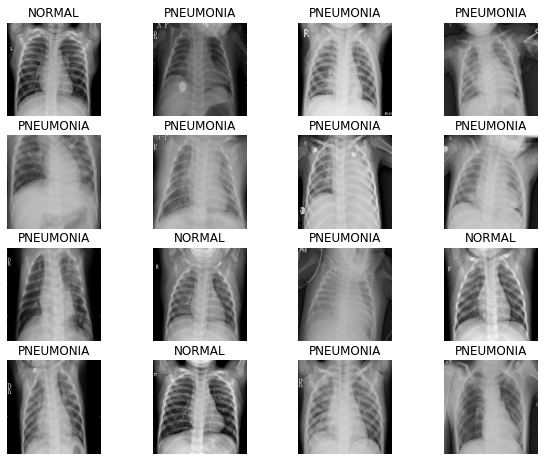

In [16]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds_ori))
show_batch(image_batch.numpy(), label_batch.numpy())

* 제가 봐도 구분하기 쉬운 사진도 있지만, 구분하기 어려운 사진도 있네요.

* augmentation 이미지를 시각화 해보겠습니다.

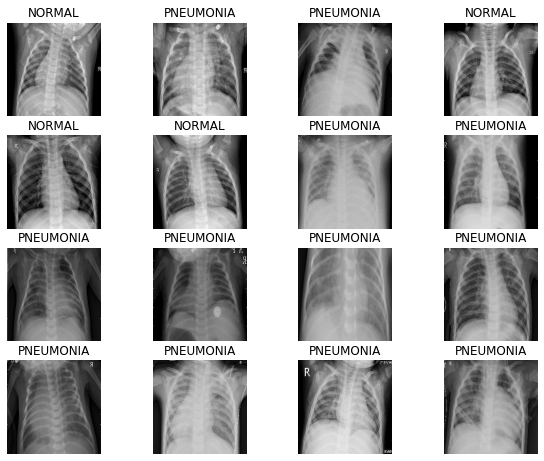

In [17]:
image_aug_batch, label_aug_batch = next(iter(train_aug_ds))

show_batch(image_aug_batch.numpy(), label_aug_batch.numpy())

* augmentation가 잘 만들어진것 같습니다.

## 모델 설계

* Convolution block을 만듭니다.

In [18]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

* Dense Block을 만듭니다.

In [19]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

* 모델을 만듭니다.

In [20]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.7),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.7),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

*  Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용되고 있습니다.

* 위에서 언급했던 데이터의 불균형을 처리하기 위해 가중치를 만들겠습니다.

In [21]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


* 사진이 적으면 가중치를 높여 사용하고, 많으면 낮춰 사용하겠습니다.

### 모델 학습

In [22]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

* 학습하기전 모델을 시각화 해보겠습니다.

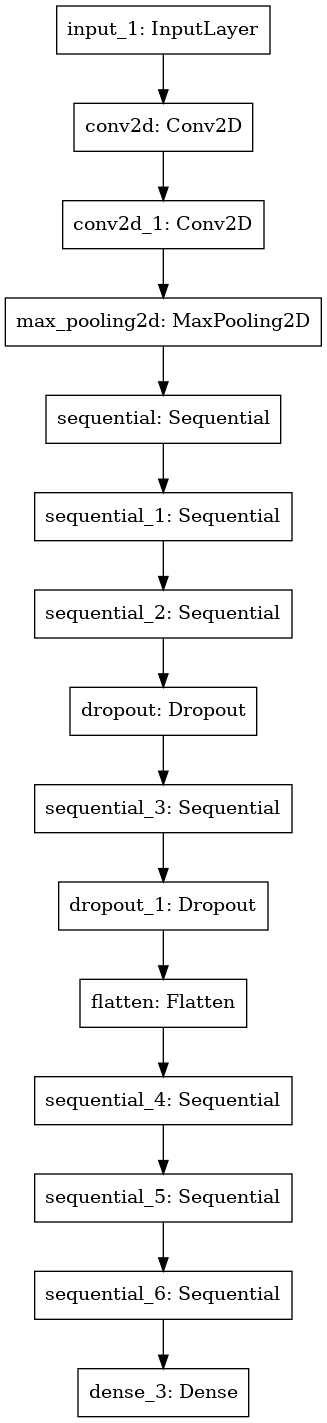

In [23]:
plot_model(model)

* 처음 이미지만 기지고 학습시켜 보겠습니다.

In [24]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_ori,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_ori,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 97s 251ms/step - loss: 0.7929 - accuracy: 0.5935 - precision: 0.8302 - recall: 0.5716 - val_loss: 0.5785 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 64s 247ms/step - loss: 0.3453 - accuracy: 0.8509 - precision: 0.9607 - recall: 0.8351 - val_loss: 0.8059 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 64s 247ms/step - loss: 0.2610 - accuracy: 0.8942 - precision: 0.9676 - recall: 0.8865 - val_loss: 0.7953 - val_accuracy: 0.7385 - val_precision: 0.7380 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 65s 249ms/step - loss: 0.2476 - accuracy: 0.8981 - precision: 0.9677 - recall: 0.8934 - val_loss: 0.4114 - val_accuracy: 0.7933 - val_precision: 0.7812 - val_recall: 0.9987
Epoch 5/25
261/261 [==============================] - 64s 246ms/step - loss: 0.2227 - accura

* 시각화 해보겠습니다.

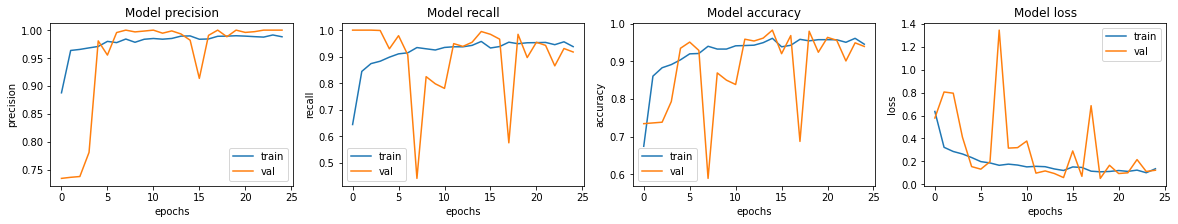

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

* dropout을 사용했지만 val 값이 모두 안정적이라고 볼수 없을 것 같습니다.

In [26]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 7s 166ms/step - loss: 0.3744 - accuracy: 0.8686 - precision: 0.8532 - recall: 0.9538
Loss: 0.3743954300880432,
Accuracy: 0.8685897588729858,
Precision: 0.853210985660553,
Recall: 0.9538461565971375


* Accuracy가 0.86을 넘었습니다.

* augmentation 데이터셋을 가지고 학습시켜 보겠습니다.

In [30]:
with tf.device('/GPU:0'):
    model_aug = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_aug.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [31]:
with tf.device('/GPU:0'):
    history_aug = model_aug.fit(
        train_aug_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_aug_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 78s 249ms/step - loss: 0.7234 - accuracy: 0.6187 - precision: 0.8378 - recall: 0.6036 - val_loss: 0.6031 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 64s 247ms/step - loss: 0.3061 - accuracy: 0.8805 - precision: 0.9686 - recall: 0.8659 - val_loss: 0.9025 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 64s 246ms/step - loss: 0.2624 - accuracy: 0.8916 - precision: 0.9664 - recall: 0.8861 - val_loss: 0.2045 - val_accuracy: 0.9404 - val_precision: 0.9769 - val_recall: 0.9411
Epoch 4/25
261/261 [==============================] - 65s 251ms/step - loss: 0.2356 - accuracy: 0.9010 - precision: 0.9735 - recall: 0.8926 - val_loss: 0.2375 - val_accuracy: 0.8952 - val_precision: 0.9910 - val_recall: 0.8655
Epoch 5/25
261/261 [==============================] - 66s 253ms/step - loss: 0.2144 - accura

* 시각화 해보겠습니다.

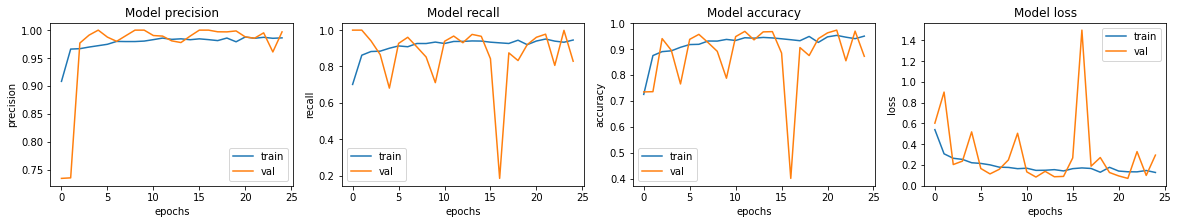

In [32]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_aug.history[met])
    ax[i].plot(history_aug.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

* 기본 이미지만 사용했을 때 모다 조금 안정적입니다.

In [33]:
loss, accuracy, precision, recall = model_aug.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 7s 161ms/step - loss: 0.5435 - accuracy: 0.8221 - precision: 0.8496 - recall: 0.8692
Loss: 0.5435153841972351,
Accuracy: 0.8221153616905212,
Precision: 0.8496240377426147,
Recall: 0.8692307472229004


* 하지만 Accuracy는 0.82로 조금 떨어졌습니다.

## 회고
* 이번 노드는 많은 시도를 해봤습니다. <br/> Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용었는데 Dropout 논문을 논문 스터디에서 읽어보았는데 max_norm과 같이 사용했을때 가장 효과가 좋았다는 실험 내용이 있었습니다.<br/> max_norm 또한 regularization이기 때문에 Batch Normalization대신 사용해서 성능을 향상시키기 위해 모델을 설계했는데 항상 짜여진 모델만 사용하다보니 직접 모델을 설계하는 과정에서 계속 실패해서 결국은 못했습니다. 다음엔 꼭 적용시켜 보고 싶습니다.
* Dropout은 일반적으로 0.5의 확률로 사용한다고 해서 그것만 수정했고 실제로 사용하기 전 0.7도 안되었는데 사용하고 나서 0.86이 나왔습니다.
> 퍼실님의 말씀을 들어보니 학습시킬때마다 확률이 변한다고 합니다.
> 이 부분에 있어 Dropout 논문을 참고해서 생각해 보았는데, 히든레이어에서 노드를 사용할지 안할지 정하기 때문에 매번 학습할때마다 다른 모델로 학습해 합쳐져 앙상블의 효과가 있다고 합니다. 그래서 노드를 잘 골라서 학습할 때가 있고, 그렇지 않을때가 있다고 생각합니다.
* 이번 노드를 통해 직접 모델을 설계하는게 어렵다는걸 알았고, 다음부터는 직접 설계해보는 시도를 해봐야 할것 같습니다.